In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import numpy as np
import glob
from scipy.stats import mannwhitneyu

# Result visualization

In [34]:
cwd = os.getcwd()
n = 100 # nb of random partitions
k = 5000 # nb of max top_k_edges selected
m = 10 # number of iterations on confounder-based partitions
ct_sels = ['BRCA', 'CESC', 'COAD', 'GBM', 'HNSC', 'KIRC', 'KIRP', 'LUSC', 'PCPG', 'READ', 'STAD'] # string identifiers of cohorts
confs = ['age', 'sex', 'race', 'stage'] # string identifiers of confounders/variables
algs = ['ARACNE', 'CEMI', 'GENIE3', 'GRNBOOST2', 'WGCNA'] # string identifiers of algorithms
alpha = 0.05

### Read data from Jaccard Indices for all tools, confounders, cohorts and partition types

In [4]:
JI = pd.DataFrame(columns = ['Confounder/\nvariable', 'Cohort', 'Method', 'Partition type', 'partID', 'k', 'mean JI'])
for alg_sel in algs:
    for conf_sel in confs:
        for ct_sel in ct_sels:
            path = os.path.join(cwd, alg_sel, 'JI_'+str(alg_sel)+'_'+str(ct_sel))
            for i in range(m):
                filename = 'cb'+'_'+str(i)+'_'+alg_sel+'_'+conf_sel+'_'+ct_sel+'_jaccInd.csv'
                try:
                    df_conf = pd.read_csv(os.path.join(path, filename), sep=',', header=0)
                    df_conf['partID'] = i
                    df_conf['Partition type'] = 'confounder-based'
                    df_conf['Method'] = alg_sel
                    df_conf['Cohort'] = ct_sel
                    df_conf['Confounder/\nvariable'] = conf_sel
                except:
                    continue
                JI = pd.concat([JI, df_conf])
                
for alg_sel in algs:
    for conf_sel in confs:
        for ct_sel in ct_sels:
            path = os.path.join(cwd, alg_sel, 'JI_'+str(alg_sel)+'_'+str(ct_sel))
            for i in range(n):
                filename = 'rnd'+'_'+str(i)+'_'+alg_sel+'_'+conf_sel+'_'+ct_sel+'_jaccInd.csv'
                try:
                    df_rnd = pd.read_csv(os.path.join(path, filename), sep=',', header=0)
                    df_rnd['partID'] = i
                    df_rnd['Partition type'] = 'random'
                    df_rnd['Method'] = alg_sel
                    df_rnd['Cohort'] = ct_sel
                    df_rnd['Confounder/\nvariable'] = conf_sel
                except:
                    continue
                JI = pd.concat([JI, df_rnd])

print(JI.head())

  Confounder/\nvariable Cohort  Method    Partition type partID    k  \
0                   age   BRCA  ARACNE  confounder-based      0   10   
1                   age   BRCA  ARACNE  confounder-based      0   60   
2                   age   BRCA  ARACNE  confounder-based      0  110   
3                   age   BRCA  ARACNE  confounder-based      0  160   
4                   age   BRCA  ARACNE  confounder-based      0  210   

    mean JI  size intersection  size union      state  
0  0.428571                6.0        14.0  filled01_  
1  0.395349               34.0        86.0  filled01_  
2  0.401274               63.0       157.0  filled01_  
3  0.367521               86.0       234.0  filled01_  
4  0.368078              113.0       307.0  filled01_  


In [5]:
JI_all = JI.copy()
print(JI.head())
JI_all['Confounder/\nvariable'] = JI_all['Confounder/\nvariable'].replace(['race'], 'ethnicity')
JI_all.rename(columns={'mean JI': 'Mean JI'}, inplace=True)
confs = ['age', 'ethnicity', 'sex', 'stage']
JI_all = JI_all[JI_all['k']%100 == 10]
JI_all['Method'] = JI_all['Method'].replace(['ARACNE'], 'ARACNe-AP').replace(['CEMI'], 'CEMiTool').replace(['GRNBOOST2'], 'GRNBoost2')
algs = ['ARACNe-AP', 'CEMiTool', 'GENIE3', 'GRNBoost2', 'WGCNA'] # string identifiers of algorithms
print(JI_all.head())
JI_all['Cohort x\nConfounder'] = JI_all['Cohort'] + ' x ' + JI_all['Confounder/\nvariable']



  Confounder/\nvariable Cohort  Method    Partition type partID    k  \
0                   age   BRCA  ARACNE  confounder-based      0   10   
1                   age   BRCA  ARACNE  confounder-based      0   60   
2                   age   BRCA  ARACNE  confounder-based      0  110   
3                   age   BRCA  ARACNE  confounder-based      0  160   
4                   age   BRCA  ARACNE  confounder-based      0  210   

    mean JI  size intersection  size union      state  
0  0.428571                6.0        14.0  filled01_  
1  0.395349               34.0        86.0  filled01_  
2  0.401274               63.0       157.0  filled01_  
3  0.367521               86.0       234.0  filled01_  
4  0.368078              113.0       307.0  filled01_  
  Confounder/\nvariable Cohort     Method    Partition type partID    k  \
0                   age   BRCA  ARACNe-AP  confounder-based      0   10   
2                   age   BRCA  ARACNe-AP  confounder-based      0  110   
4     

### 1) Plot mean JI over k per cohort and per confounder

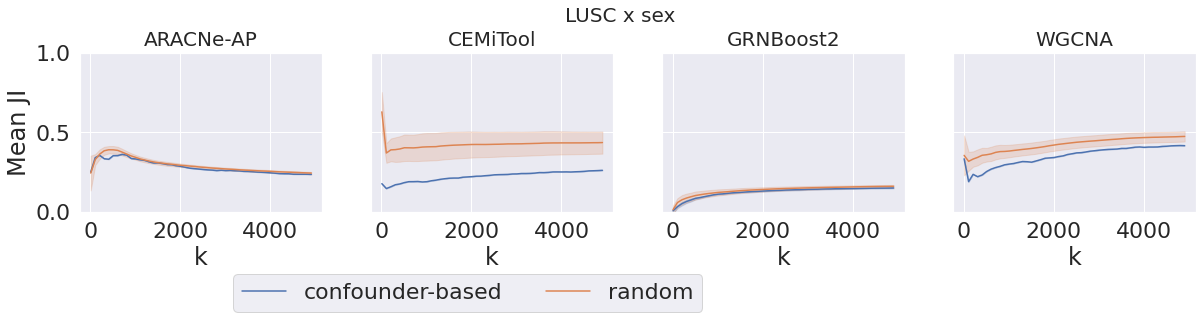

In [41]:
sns.set(font_scale=2)
sns.set_style('darkgrid')
for ct_sel in ['STAD']:
    JI_ct = JI_all[JI_all['Cohort'] == ct_sel]
    for conf in ['age']:
        JI_conf = JI_ct[JI_ct['Confounder/\nvariable'] == conf]
        if len(JI_conf) == 0:
            continue
        i = 0
        cols = sorted(list(set(JI_conf['Method'].values)))
        fig, axs = plt.subplots(1, len(cols), figsize=(5*len(cols), 0.73*len(cols)), sharey=True)
        plt.ylim(0, 1)
        for alg in cols:
            JI_alg = JI_conf[JI_conf['Method'] == alg]
            g = sns.lineplot(JI_alg, x='k', y='Mean JI', errorbar='sd', ax=axs[i], hue='Partition type', legend=(i==0))
            axs[i].set_title(alg, fontdict={'fontsize': 20}, y=1.01)
            #axs[i].text(s=f'{ct_sel} x {conf}', y=-3.8, x=2.7, rotation=270, transform=ax.transAxes)
            i += 1
        t = plt.suptitle(f'{ct_sel} x {conf}', fontsize=20, y=1.1)
        sns.move_legend(axs[0], "lower center", frameon=True, ncol=len(cols), title=None, bbox_to_anchor=(1.6,-0.7))
        fig.savefig(f'{ct_sel}_{conf}_lineplot.pdf', bbox_inches='tight')
        #g.savefig(f'{ct_sel}_{conf}_lineplot.pdf')


## test conf < rnd with one-sided Mann-Whitney-U  test for each k

In [18]:
mwus = pd.DataFrame(columns=['Method', 'Cohort', 'Confounder/\nvariable', 'k', 'mwu.pvalue'])
for alg_sel in algs:
    JI_ = JI_all[JI_all['Method'] == alg_sel]
    for cohort in ct_sels:
        coh = JI_[JI_['Cohort'] == cohort]
        for conf_sel in confs:
            conf = coh[coh['Confounder/\nvariable'] == conf_sel]
            if len(conf) == 0:
                continue
            c = conf[conf['Partition type']=='confounder-based']
            r = conf[conf['Partition type']=='random']
            for k in sorted(list(set(c['k']))):
                c_k = c[c['k'] == k]
                r_k = r[r['k'] == k]
                mwu = mannwhitneyu(c_k['Mean JI'],r_k['Mean JI'], alternative='less')
                df = pd.DataFrame([[alg_sel, cohort, conf_sel, k, mwu.pvalue]], columns=['Method', 'Cohort', 'Confounder/\nvariable', 'k', 'mwu.pvalue'])
                mwus = pd.concat([mwus, df])
mwus.reset_index(inplace=True)
mwus = mwus.drop('index', axis=1).drop('k', axis=1)
count = mwus.groupby(['Method', 'Cohort', 'Confounder/\nvariable']).count().reset_index()
count.rename(columns={'mwu.pvalue':'total.pvalues'}, inplace=True)
sign_ = mwus[mwus['mwu.pvalue'] < alpha]
sign_ = sign_.groupby(['Method', 'Cohort', 'Confounder/\nvariable']).count().reset_index()
sign_.rename(columns={'mwu.pvalue':'sign.pvalues'}, inplace=True)


In [19]:
sign = pd.merge(count, sign_,  how='left', left_on=['Method', 'Cohort', 'Confounder/\nvariable'], 
              right_on=['Method', 'Cohort', 'Confounder/\nvariable']).fillna(0)


In [20]:
sign['frac'] = sign['sign.pvalues']/sign['total.pvalues']

In [21]:
sign

,Method,Cohort,Confounder/\nvariable,total.pvalues,sign.pvalues,frac
0,ARACNe-AP,BRCA,age,50,49.0,0.98
1,ARACNe-AP,BRCA,ethnicity,50,48.0,0.96
2,ARACNe-AP,BRCA,stage,50,49.0,0.98
3,ARACNe-AP,CESC,age,50,49.0,0.98
4,ARACNe-AP,CESC,ethnicity,50,2.0,0.04
...,...,...,...,...,...,...
109,WGCNA,READ,stage,50,50.0,1.00
110,WGCNA,STAD,age,50,40.0,0.80
111,WGCNA,STAD,ethnicity,50,38.0,0.76
112,WGCNA,STAD,sex,50,0.0,0.00


In [22]:
import datetime
stamp = datetime.datetime.now().strftime("%d-%m-%Y_%H:%M:%S")
sign.to_csv(f'mwu_pvalues_{str(stamp)}.csv')

<Figure size 432x288 with 0 Axes>

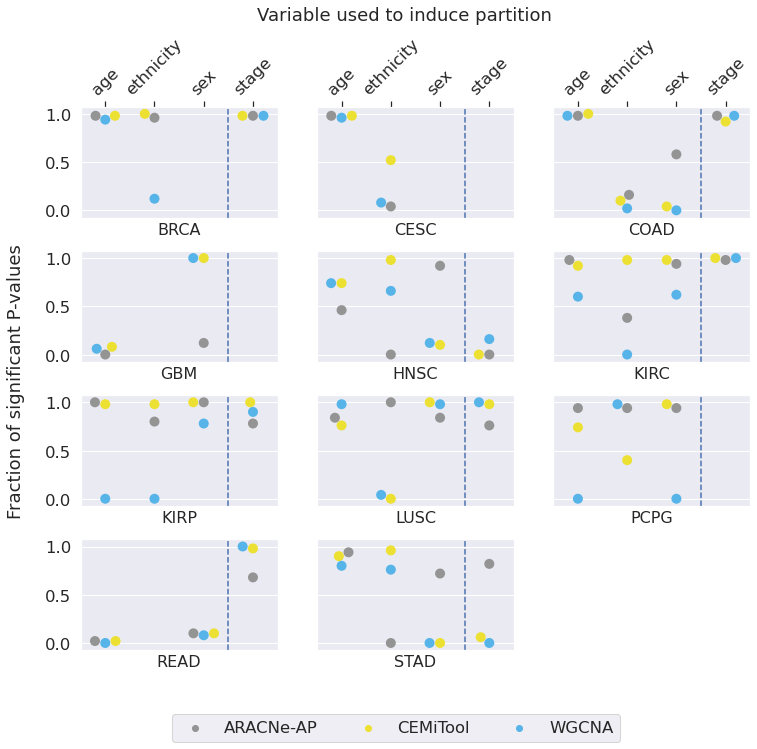

In [23]:
import math
plt.tight_layout()
sns.set(font_scale=1.5)
sns.set_style("darkgrid")
plt.rcParams['axes.titley'] = -0.2
fig, axs = plt.subplots(4, 3, figsize=(12, 10), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.3)
fig.text(0.5, 1.0,'Variable used to induce partition', ha='center')
fig.text(0.04, 0.5, 'Fraction of significant P-values', va='center', rotation='vertical')
plt.yticks([0.0, 0.5, 1.0])

_mwus = pd.DataFrame(sign).reset_index()
_mwus = _mwus[(_mwus['Method'] != 'GRNBoost2') & (_mwus['Method'] != 'GENIE3')]
_mwus['Confounder/\nvariable'] = pd.Categorical(_mwus['Confounder/\nvariable'], ['age', 'ethnicity', 'sex', 'stage'])

i = j = 0
for ct_sel in ct_sels:
    axs[i,j].set_ylim([-0.075, 1.075])
    axs[i,j].set_title(ct_sel, fontdict={'fontsize': 16})
    axs[i,j].axvline(x=2.5, linestyle='--')
    if i == 0:
        axs[i,j].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    else:
        axs[i,j].tick_params(top=False, labeltop=False, bottom=False, labelbottom=False)
    for tick in axs[i,j].get_xticklabels():
        tick.set_rotation(45)
    g = sns.swarmplot(_mwus[_mwus['Cohort'] == ct_sel], x='Confounder/\nvariable', y='frac', hue='Method', 
                    ax=axs[i,j], s=10, palette=sns.color_palette('colorblind')[7:10], legend=(i==j==0))
    g.set(xlabel=None, ylabel=None)
    j = (j + 1) % 3
    i = i + 1 if j == 0 else i
    
sns.move_legend(axs[0,0], "lower center", frameon=True, ncol=3, title=None, bbox_to_anchor=(1.6,-4.8))
fig.delaxes(axs[3,2])
fig.savefig(f'varplot{stamp}.pdf', bbox_inches='tight')